In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import time
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Loading the data and setting index to 'respondent_id' column
url_train_data = 'https://raw.githubusercontent.com/bakhtiyar0309/Flu-Shot-Learning/main/data/training_set_features.csv'
url_test_data  = 'https://raw.githubusercontent.com/bakhtiyar0309/Flu-Shot-Learning/main/data/test_set_features.csv'
url_labels = 'https://raw.githubusercontent.com/bakhtiyar0309/Flu-Shot-Learning/main/data/training_set_labels.csv'
df_train = pd.read_csv(url_train_data, index_col='respondent_id') # dataset of training features 
df_test = pd.read_csv(url_test_data)   # dataset of testing features 
df_labels = pd.read_csv(url_labels, index_col='respondent_id')    # labels (targets) for training features
 


#### **Step 1: Prepare DataSet**

Task description: Prepare your dataset: encode categorical variables (if any), handle missing variables (if any), generate new features (if you have some intuition that these features can be useful). Preprocess target variable if needed (e.g., combine various classification problems into a single one or convert the target variable to a binary one.) For each transformation give a clear explanation of your motivation. (7 points)


1.1 Handling Missing Data

In [ ]:
# Change 'Sex' str column to numeric  
df_train['sex_male'] = df_train['sex'].apply(lambda x: 0.0 if x == 'Female' else 1.0)
df_train = df_train.drop('sex', axis=1)

df_test['sex_male'] = df_test['sex'].apply(lambda x: 0.0 if x == 'Female' else 1.0)
df_test = df_test.drop('sex', axis=1)

df_train.head(3)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,sex_male
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,1.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,1.0


In [ ]:
#combine feature data with labels data - required for EDA
pd.set_option('display.max_columns', 500)
df = pd.merge(df_train, df_labels, on='respondent_id', how='inner')

In [ ]:
#divide columns into numerical and categorical ones
num_columns = df_train.select_dtypes('float64').columns
cat_columns = df_train.select_dtypes('object').columns
id_column_test = df_test['respondent_id']

df_train_num = df_train.loc[:, num_columns]
df_train_cat = df_train.loc[:, cat_columns]

df_test_num = df_test.loc[:, num_columns]
df_test_cat = df_test.loc[:, cat_columns]

In [ ]:
# Impute NANs in numerical columns with median values
df_train_num_imputed = pd.DataFrame(SimpleImputer(missing_values=np.nan, strategy='median').fit_transform(df_train_num),
                                            columns = df_train_num.columns)
df_test_num_imputed = pd.DataFrame(SimpleImputer(missing_values=np.nan, strategy='median').fit_transform(df_test_num), 
                                           columns = df_test_num.columns)


In [ ]:
# Scale numerical columns 
scaler_train = StandardScaler()
scaler_test = StandardScaler()

df_train_num_imputed = pd.DataFrame(scaler_train.fit_transform(df_train_num_imputed), 
                                    columns = df_train_num_imputed.columns)

df_test_num_imputed = pd.DataFrame(scaler_test.fit_transform(df_test_num_imputed), 
                                   columns = df_test_num_imputed.columns)

In [ ]:
# Impute NANs in categorical columns with 'no_response' values
df_train_cat_imputed = pd.DataFrame(SimpleImputer(missing_values=np.nan, strategy='constant', fill_value = 'no_response').fit_transform(df_train_cat),
                                            columns = df_train_cat.columns)
df_test_cat_imputed = pd.DataFrame(SimpleImputer(missing_values=np.nan, strategy='constant', fill_value = 'no_response').fit_transform(df_test_cat), 
                                           columns = df_test_cat.columns)


In [ ]:
# Merge numerical and categorical columns
df_train = pd.concat([df_train_num_imputed, df_train_cat_imputed], axis = 1)
df_test = pd.concat([df_test_num_imputed, df_test_cat_imputed], axis = 1)

In [ ]:
# Check point
df_train.count()

h1n1_concern                   26707
h1n1_knowledge                 26707
behavioral_antiviral_meds      26707
behavioral_avoidance           26707
behavioral_face_mask           26707
behavioral_wash_hands          26707
behavioral_large_gatherings    26707
behavioral_outside_home        26707
behavioral_touch_face          26707
doctor_recc_h1n1               26707
doctor_recc_seasonal           26707
chronic_med_condition          26707
child_under_6_months           26707
health_worker                  26707
health_insurance               26707
opinion_h1n1_vacc_effective    26707
opinion_h1n1_risk              26707
opinion_h1n1_sick_from_vacc    26707
opinion_seas_vacc_effective    26707
opinion_seas_risk              26707
opinion_seas_sick_from_vacc    26707
household_adults               26707
household_children             26707
sex_male                       26707
age_group                      26707
education                      26707
race                           26707
i

1.2 Encode categorical features

In [ ]:
dummy_columns_train = pd.get_dummies(df_train[cat_columns])
df_train = pd.concat((df_train, dummy_columns_train), axis=1)
df_train = df_train.drop(df_train[cat_columns], axis=1)

dummy_columns_test = pd.get_dummies(df_test[cat_columns])
df_test = pd.concat((df_test, dummy_columns_test), axis=1)
df_test = df_test.drop(df_test[cat_columns], axis=1)

#### **Step 2. Exploratory Data Analysis**

Task description: Perform an exploratory analysis of the data via visualization with Seaborn. Try to find meaningful patterns in the data which can be used to make a machine learning task more specific or to help with selection and tuning ML models. Perform additional preprocessing of your data if your findings suggest this (again, all steps should be motivated). If there are several options for target variables, you can select some of them after this step with a couple of sentences explaining your choice. (6 points).

**2.1 Univariate Data Analysis**

 1.Lets begin our analysis with the target values: H1N1 and Seasonal Flu vaccine 
distributions 

In [ ]:
# Show all the columns in our dataset
df.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'income_poverty', 'marital_status', 'rent_or_own',
       'employment_status', 'hhs_geo_region', 'census_msa', 'household_adults',
       'household_children', 'employment_industry', 'employment_occupation',
       'sex_male', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

In [ ]:
# split the data into feature and target variables sets
train = df.drop(['h1n1_vaccine', 'seasonal_vaccine'], axis=1)
labels = df[['h1n1_vaccine','seasonal_vaccine']]

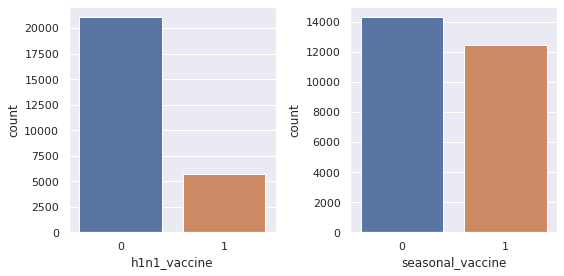

In [ ]:
# Distribution plot for target variables
plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True
f, ax = plt.subplots(1, 2);
sns.countplot(data=labels, x='h1n1_vaccine', ax=ax[0]);
sns.countplot(data=labels, x='seasonal_vaccine', ax=ax[1]);
plt.show();

Observations:


1.  For the h1n1_vaccine distribution, we see that about 1/4 of respondents received this type of vaccination.
2.  While, the seasonal vaccine adoption is nearly evenly distributed among the population.



**2.2 Bivariate Data Analysis**

**1**. Explore how target variables relate to each other 

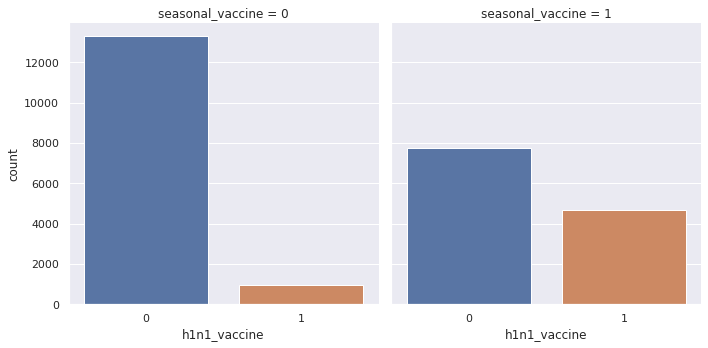

In [ ]:
# catplot for h1n1_vaccine and seasonal_vaccine
sns.catplot(x='h1n1_vaccine', col='seasonal_vaccine', kind='count', data=labels);

In [ ]:
pd.crosstab(labels['h1n1_vaccine'],labels['seasonal_vaccine'])

seasonal_vaccine,0,1
h1n1_vaccine,,
0,13295,7738
1,977,4697


Observation:


1.   We can note that the majority of people who received h1n1_vaccine1 also got the seasonal_vaccine.  
2.   However, with respect to seasonal_vaccine, smaller portion of them acquired the h1n1_vaccine.



*2*. Analyze how feature variables are related to each other

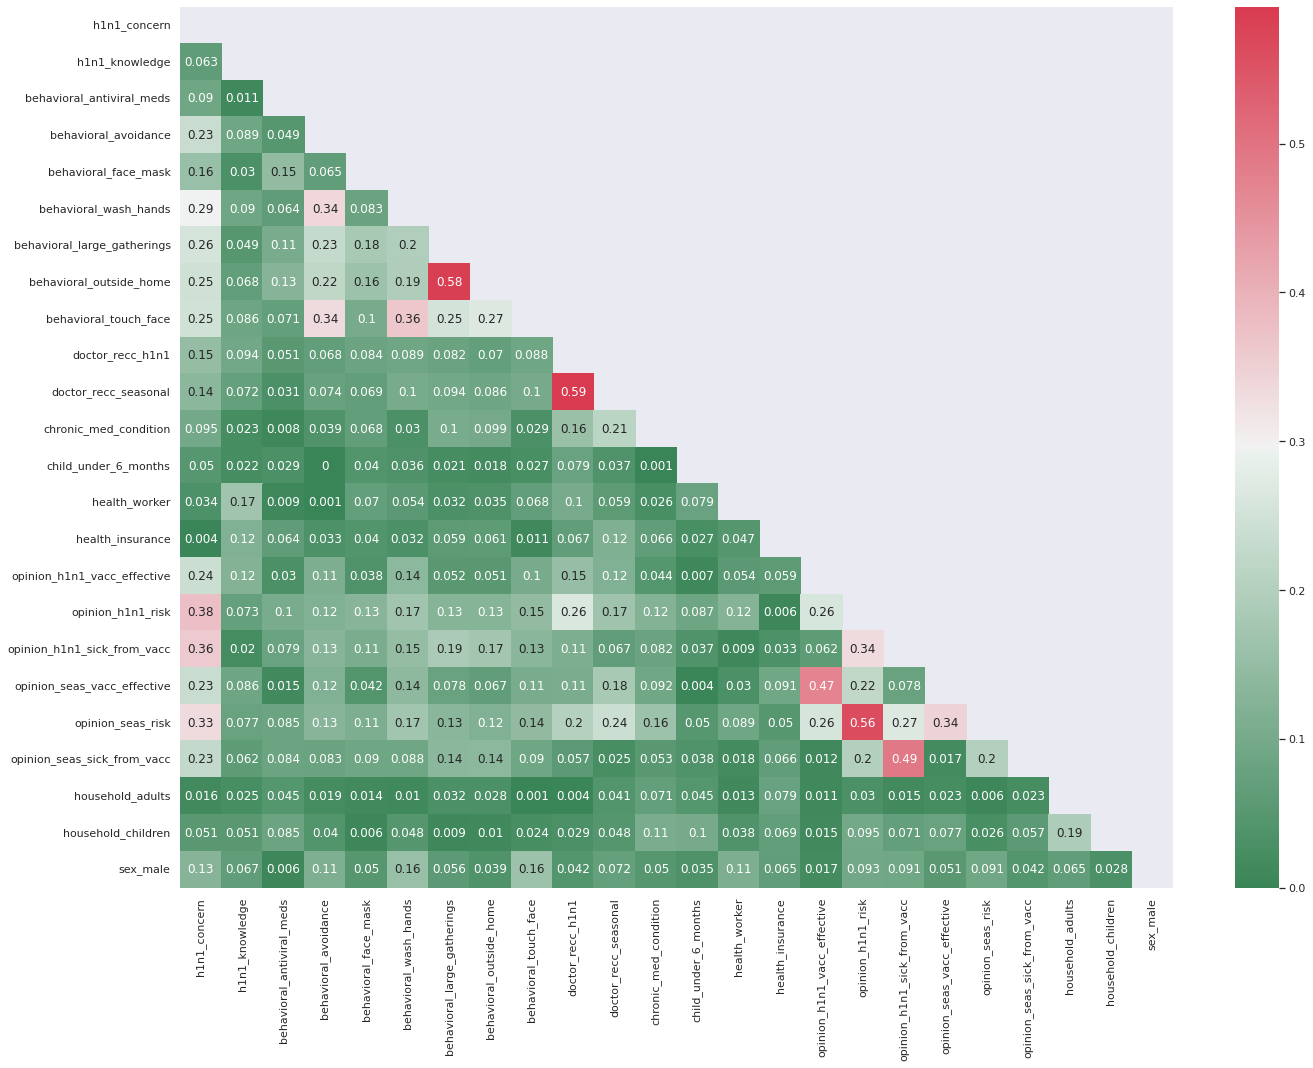

In [ ]:
## Heatmap 
corr_matrix = train.corr().abs().round(3)
mask = np.zeros_like(corr_matrix)
cmap = sns.diverging_palette(500, 8, as_cmap=True)
mask[np.triu_indices_from(mask)] = True
mask
plt.figure(figsize=(20,15))

sns.heatmap(corr_matrix, annot=True, cmap=cmap, mask=mask);

Observations: 

1.   Respondents opinions on flu vaccine effectiveness are strongly correlated.
2.   Respondents concerns on the risk of getting sick with flu, and worries of getting sick from taking vaccine are also strongly related.
3.   Level of concern of respondents about the flu shows correlations with their behovioral metrics like avoiding close contact with others having flu-like symptoms or reduing time at large gatherings. 
4.   People who receive doctors recommendation to take h1n1_vaccine more likely to recive the doctors recommendation to adopt seasonal_vaccine.
5.   Doctors recommendation to take flu vaccines are correlated with the opinon of respondents on risks of getting sick with flu.




 *3*. Analyze how feature variables are related to target variables 

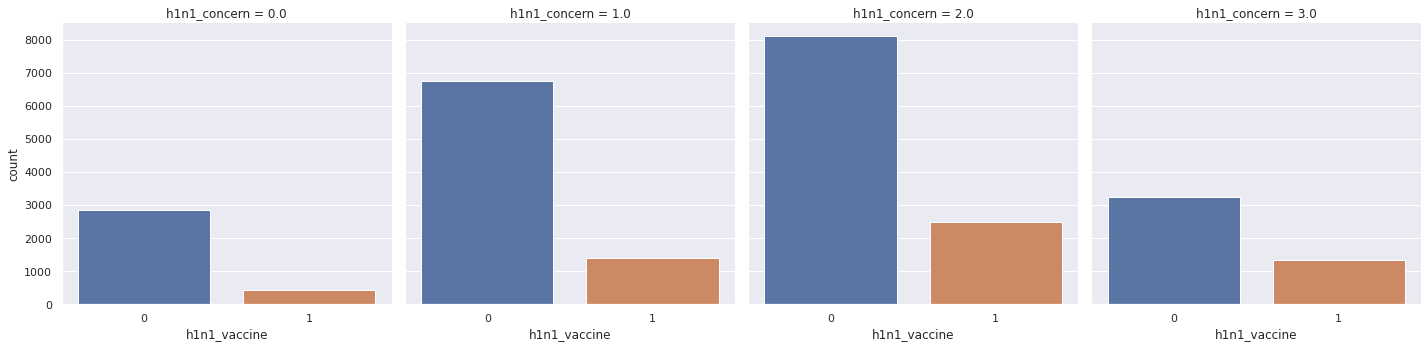

In [ ]:
# Degree of concern about the virus
sns.catplot(x='h1n1_vaccine', col='h1n1_concern', kind='count', data=df);

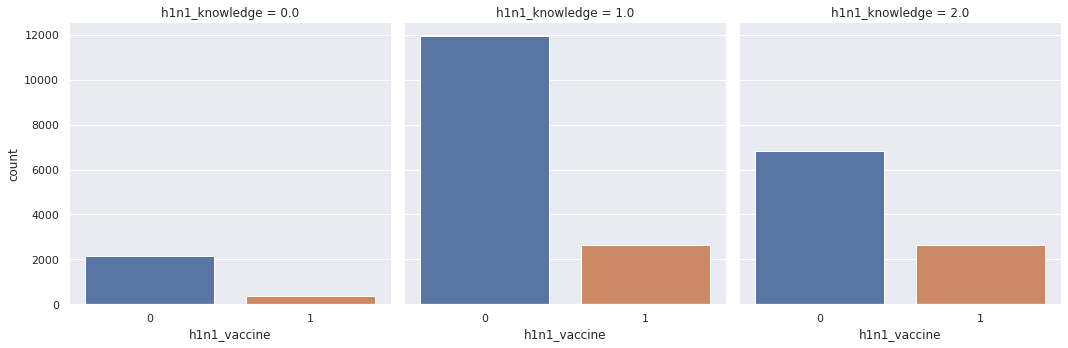

In [ ]:
# level of knowledge
sns.catplot(x='h1n1_vaccine', col='h1n1_knowledge', kind='count', data=df);

In [ ]:
# Outputs the percentage for each subgroup 
def percent_plot(x, y, ax): 
  df1 = df.groupby(x)[y].value_counts(normalize=True)
  df1 = df1.mul(100)
  df1 = df1.rename('percent').reset_index()


  g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1,legend=False, ax=ax)
  g.ax.set_ylim(0,100)

  g.fig.get_axes()[0].legend(title=y,loc='upper right')

  for p in g.ax.patches:
      txt = str(p.get_height().round(2)) + '%'
      txt_x = p.get_x() 
      txt_y = p.get_height()
      g.ax.text(txt_x,txt_y,txt)


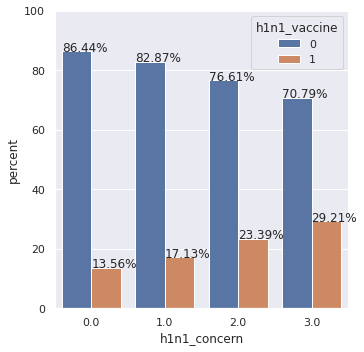

In [ ]:
#Catplot relative to percentage within each concern level.
percent_plot('h1n1_concern', 'h1n1_vaccine', ax=None)

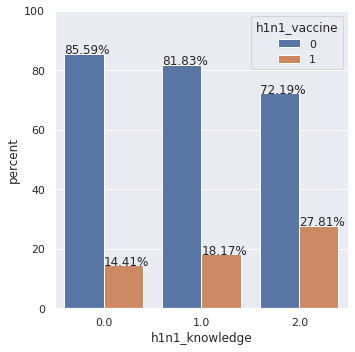

In [ ]:
#Catplot relative to percentage within each knowledge level.
percent_plot('h1n1_knowledge', 'h1n1_vaccine', ax=None)

Observations:

1.   We can observe that the higher the concern for flu virus among respondents and the knowledge level about the virus, thus the greater proportion of people receive the vaccination. 

    So increasing the knowledge and concern level among population is one of the ways to increase the vaccination rate. 

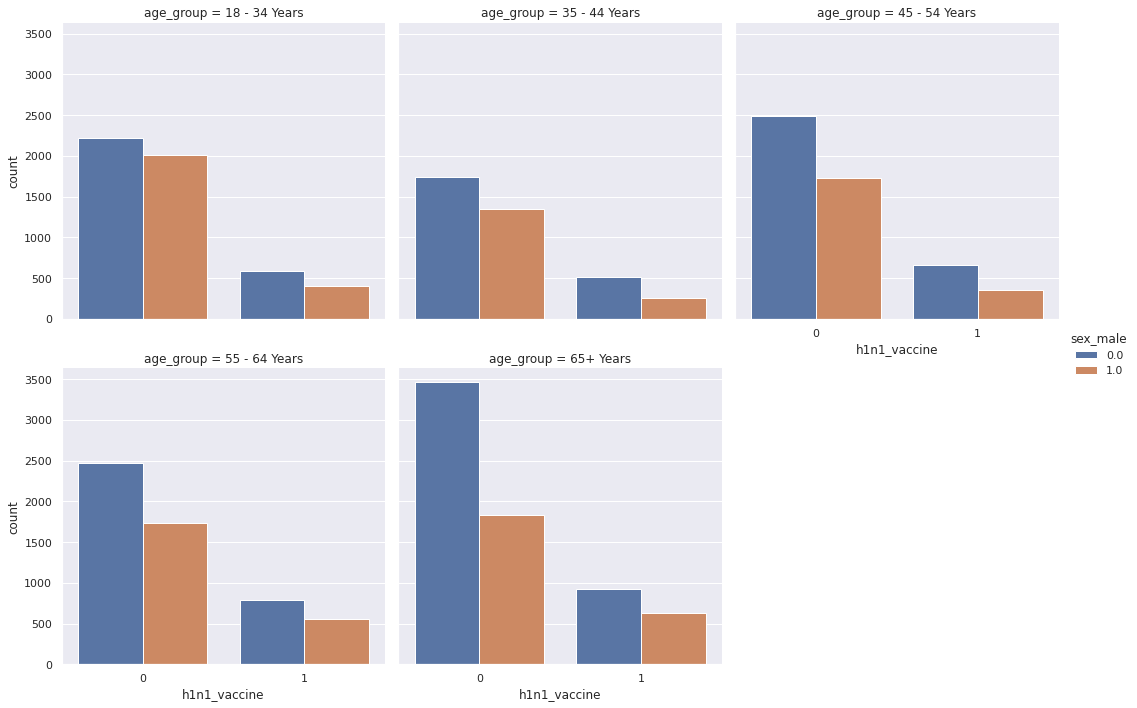

In [ ]:
# Analyse how vaccination numbers differ by the age and gender categories among respondents 

# for h1n1_vaccine
sns.catplot(x='h1n1_vaccine', col='age_group', col_wrap = 3, hue='sex_male', col_order = ['18 - 34 Years','35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years' ],kind='count', data=df);
plt.show()

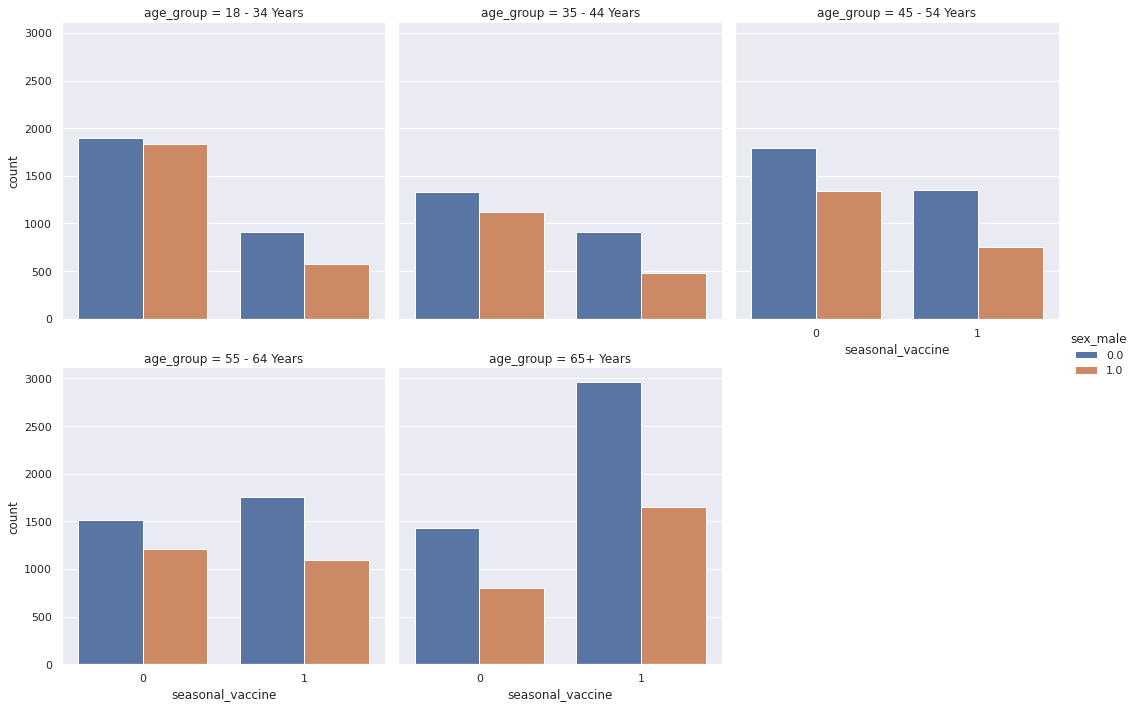

In [ ]:
# similarly for seasonal_vaccine
sns.catplot(x='seasonal_vaccine', col='age_group', col_wrap = 3, hue='sex_male', col_order = ['18 - 34 Years','35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years' ], kind='count', data=df);
plt.show()

Observations: 

1. With countplot it is not clear how vaccination rates differs among various age groups. 
3. Females received the flu shots (both types) more than men among different age groups.

In [ ]:
# Plot a histogram of features variables vs target variables 
def feature_target_plot(col, target, data, ax=None):
    plot = df.groupby([col])[target].value_counts(normalize=True).reset_index(name='percentage')
    g = sns.histplot(y = col , hue = target , weights= 'percentage',
             multiple = 'stack', data=plot,shrink = 0.7, ax=ax)
    sns.move_legend(g, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title_fontsize=14)

    ax.invert_yaxis()
    ax.set(xlabel=None)

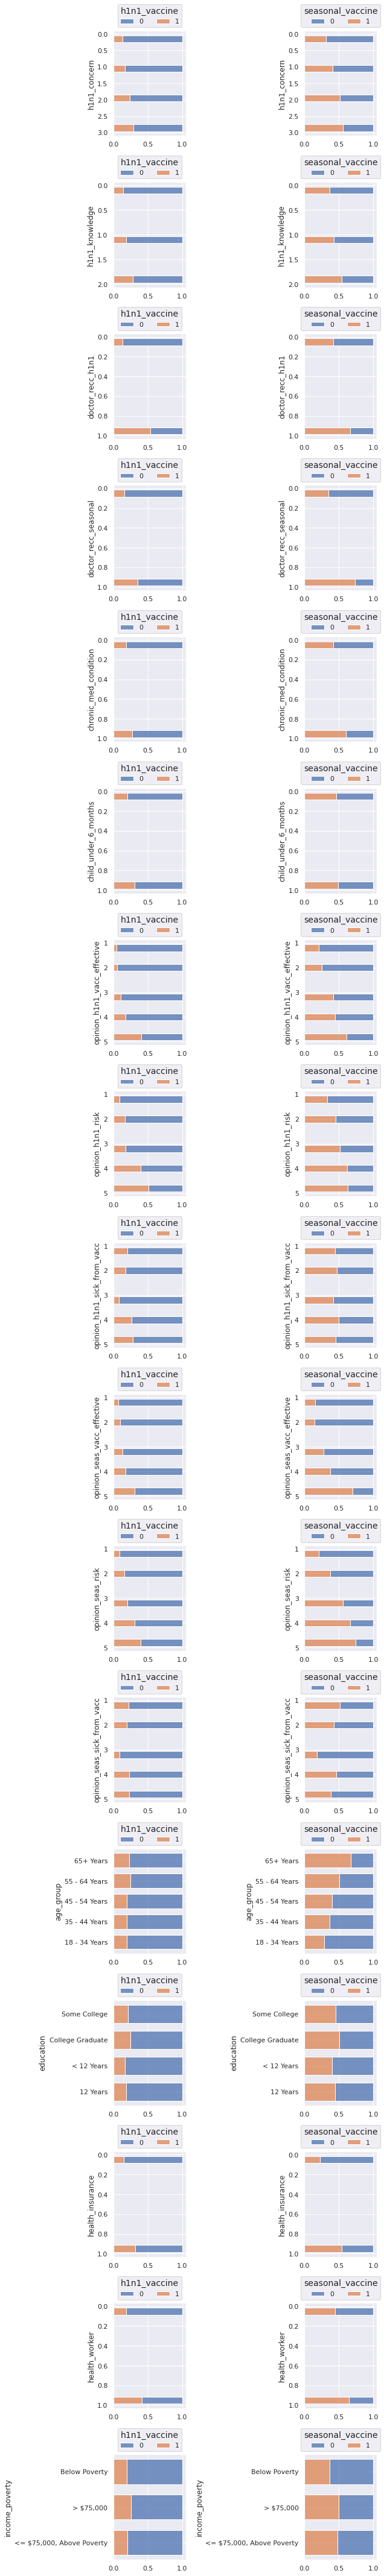

In [ ]:
# Histogram plotting
cols = [ 'h1n1_concern' ,'h1n1_knowledge', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
                  'chronic_med_condition', 'child_under_6_months', 'opinion_h1n1_vacc_effective',
                  'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 
                  'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group', 'education', 'health_insurance', 'health_worker',
                  'income_poverty']

fig, ax = plt.subplots(
    len(cols), 2, figsize=(9,len(cols)*3.5))

for idx, col in enumerate(cols):
    feature_target_plot(
        col, 'h1n1_vaccine', df, ax=ax[idx, 0]
    )
    feature_target_plot(
        col, 'seasonal_vaccine', df, ax=ax[idx, 1]
    )
fig.tight_layout()

Observations:
*   People are more inclined to have H1N1 and seasonal flu shot if they have:
>1.   Increased concern and knowledge about H1N1 flu (for both) 
 2.   If their doctor recommended to have a vaccine shot (for both) 
 3.   If they have chronic medical conditions (for both) 
 4.   If they have child under 6 months (only for h1n1_vaccine)
 5.   Opinion on vaccine effectiveness and risk of getting sick with flu without vaccine (for both)
 6.   If they are in older population group (only for seasonal vaccine)
 7.   If they do have health insurance (for both)
 8.   If the are a health workers



#### **Step 3: Models** 

Task description: Build a proper cross-validation procedure; select an appropriate measure of quality (the selection of both things should be motivated by your data). Choose an ML model reasonably; look for a good set of hyperparameters. Use the prepared cross-validation procedure to estimate the quality of prediction (9 points).

In [ ]:
# Rename some columns to further allow XGBoost work with them
df_train = df_train.rename(columns={"education_< 12 Years": "education_less_12_years", 
                   "income_poverty_<= $75,000, Above Poverty": "income_poverty_less_75000_above_poverty",
                   "income_poverty_> $75,000": "income_poverty_more_75000",
                   "census_msa_MSA, Not Principle  City": "census_msa_MSA_not_principle_city",
                   "census_msa_MSA, Principle City": "census_msa_MSA_principle_city"})

df_test = df_test.rename(columns={"education_< 12 Years": "education_less_12_years", 
                   "income_poverty_<= $75,000, Above Poverty": "income_poverty_less_75000_above_poverty",
                   "income_poverty_> $75,000": "income_poverty_more_75000",
                   "census_msa_MSA, Not Principle  City": "census_msa_MSA_not_principle_city",
                   "census_msa_MSA, Principle City": "census_msa_MSA_principle_city"})

In [ ]:
# Choose train, validation and test data
X = df_train
X_test = df_test
y_h1n1 = df_labels['h1n1_vaccine']
y_seas = df_labels['seasonal_vaccine']

In [ ]:
# Split data for H1N1 and seasonal flu
X_h1n1_train, X_h1n1_val, y_h1n1_train, y_h1n1_val = train_test_split(X, y_h1n1, test_size=0.30, random_state=7, shuffle=True, stratify=y_h1n1)
X_seas_train, X_seas_val, y_seas_train, y_seas_val = train_test_split(X, y_seas, test_size=0.30, random_state=7, shuffle=True, stratify=y_seas)

1. Comparison of several base machine learning algorithms to find the best one


1. Logistic Regression

In [ ]:
# Logistic Regression - baseline model
logistic_clf = LogisticRegression(max_iter=5000, random_state=7)
logistic_clf.fit(X_h1n1_train, y_h1n1_train)
y_pred = logistic_clf.predict_proba(X_h1n1_val)
print('H1N1 Logistic Regression ROC AUC score: {:.3}'.format(roc_auc_score(y_h1n1_val, y_pred[:, 1])))

logistic_clf = LogisticRegression(max_iter=5000, random_state=7)
logistic_clf.fit(X_seas_train, y_seas_train)
y_pred = logistic_clf.predict_proba(X_seas_val)
print('Seasonal Logistic Regression ROC AUC score: {:.3}'.format(roc_auc_score(y_seas_val, y_pred[:, 1])))


H1N1 Logistic Regression ROC AUC score: 0.835
Seasonal Logistic Regression ROC AUC score: 0.852


In [ ]:
#hyperparameters search 
start = time.time()
print("H1N1 started at:", str(time.ctime(int(start))))
# 
gs_h1n1 = GridSearchCV(LogisticRegression(max_iter=5000, random_state=7), 
                  param_grid={'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
                              'C' : np.logspace(-2, 2, 5),
                              'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
                              }, 
                  cv=5,scoring = 'roc_auc', n_jobs = -1)
gs_h1n1.fit(X_h1n1_val, y_h1n1_val)

print("H1N1 ended at:", str(time.ctime(int(time.time()))))
print('Duration: {:.3}'.format((time.time() - start) / 60), 'min')

start = time.time()
print("SEASONAL started at:", str(time.ctime(int(start))))

gs_seas = GridSearchCV(LogisticRegression(max_iter=5000, random_state=7), 
                  param_grid={'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
                              'C' : np.logspace(-2, 2, 5),
                              'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
                              }, 
                  cv=5, scoring = 'roc_auc', n_jobs = -1)
gs_seas.fit(X_seas_val, y_seas_val)

print("SEASONAL ended at:", str(time.ctime(int(time.time()))))
print('Duration: {:.3}'.format((time.time() - start) / 60), 'min')

H1N1 started at: Sun Oct 24 20:46:01 2021
H1N1 ended at: Sun Oct 24 20:54:45 2021
Duration: 8.74 min
SEASONAL started at: Sun Oct 24 20:54:45 2021
SEASONAL ended at: Sun Oct 24 21:16:56 2021
Duration: 22.2 min


In [ ]:
print( 'Parameters for H1N1: \npenalty =', gs_h1n1.best_params_['penalty'],
', C =', gs_h1n1.best_params_['C'],
', solver =', gs_h1n1.best_params_['solver'])

print( 'Parameters for Seasonal: \npenalty =', gs_seas.best_params_['penalty'],
', C =', gs_seas.best_params_['C'],
', solver =', gs_seas.best_params_['solver'])

Parameters for H1N1: 
penalty = l1 , C = 0.1 , solver = saga
Parameters for Seasonal: 
penalty = l1 , C = 0.1 , solver = saga


In [ ]:
#Scoring the performance of the model with tuned hyperparameters
logistic_clf = LogisticRegression(max_iter=5000, random_state=7, penalty='l1', C=0.1, solver='saga')
logistic_clf.fit(X_h1n1_train, y_h1n1_train)
y_h1n1_pred = logistic_clf.predict_proba(X_h1n1_val)
print('H1N1 Logistic Regression ROC AUC score: {:.3}'.format(roc_auc_score(y_h1n1_val, y_h1n1_pred[:, 1])))

logistic_clf = LogisticRegression(max_iter=5000, random_state=7, penalty='l1', C=0.1, solver='saga')
logistic_clf.fit(X_seas_train, y_seas_train)
y_seas_pred = logistic_clf.predict_proba(X_seas_val)
print('Seasonal Logistic Regression ROC AUC score: {:.3}'.format(roc_auc_score(y_seas_val, y_seas_pred[:, 1])))
print('Total Logistic Regression ROC AUC score: {:.3}'.format((roc_auc_score(y_seas_val, y_seas_pred[:,1]) + roc_auc_score(y_h1n1_val, y_h1n1_pred[:,1]))/2))


H1N1 Logistic Regression ROC AUC score: 0.836
Seasonal Logistic Regression ROC AUC score: 0.852
Total Logistic Regression ROC AUC score: 0.844


2. K Neighbors Classifier

In [ ]:
#baseline model
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_h1n1_train, y_h1n1_train) 
y_pred = knn_clf.predict_proba(X_h1n1_val)
print('H1N1 KNeighborsClassifier ROC AUC score: {:.3}'.format(roc_auc_score(y_h1n1_val, y_pred[:, 1])))

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_seas_train, y_seas_train) 
y_pred = knn_clf.predict_proba(X_seas_val)
print('Seasonal KNeighborsClassifier ROC AUC score: {:.3}'.format(roc_auc_score(y_seas_val, y_pred[:, 1])))

H1N1 KNeighborsClassifier ROC AUC score: 0.741
Seasonal KNeighborsClassifier ROC AUC score: 0.78


In [ ]:
#hyperparameters search 

start = time.time()
print("H1N1 started at:", str(time.ctime(int(start))))

gs_h1n1 = GridSearchCV(KNeighborsClassifier(), 
                       param_grid={'n_neighbors': range(1, 200, 20),
                              'weights': ['uniform', 'distance'],
                              'p': range(1, 3)
                              }, 
                       cv=5, scoring = 'roc_auc', n_jobs = -1)
gs_h1n1.fit(X_h1n1_val, y_h1n1_val)

print("H1N1 ended at:", str(time.ctime(int(time.time()))))
print('Duration: {:.3}'.format((time.time() - start) / 60), 'min')

start = time.time()
print("SEASONAL started at:", str(time.ctime(int(start))))

gs_seas = GridSearchCV(KNeighborsClassifier(), 
                       param_grid={'n_neighbors': range(1, 200, 20),
                              'weights': ['uniform', 'distance'],
                              'p': range(1, 3)
                              }, 
                       cv=5, scoring = 'roc_auc', n_jobs = -1)
gs_seas.fit(X_seas_val, y_seas_val)

print("SEASONAL ended at:", str(time.ctime(int(time.time()))))
print('Duration: {:.3}'.format((time.time() - start) / 60), 'min')

H1N1 started at: Sun Oct 24 21:20:38 2021
H1N1 ended at: Sun Oct 24 21:27:01 2021
Duration: 6.38 min
SEASONAL started at: Sun Oct 24 21:27:01 2021
SEASONAL ended at: Sun Oct 24 21:33:22 2021
Duration: 6.35 min


In [ ]:
print( 'Parameters for H1N1: \nn_neighbors =', gs_h1n1.best_params_['n_neighbors'],
'weights =', gs_h1n1.best_params_['weights'],
'p =', gs_h1n1.best_params_['p'])

print( 'Parameters for Seasonal: \nn_neighbors =', gs_seas.best_params_['n_neighbors'],
'weights =', gs_seas.best_params_['weights'],
'p =', gs_seas.best_params_['p'])

Parameters for H1N1: 
n_neighbors = 181 weights = distance p = 1
Parameters for Seasonal: 
n_neighbors = 181 weights = distance p = 1


In [ ]:
# Scoring the performance of the model with best parameters
knn_clf = KNeighborsClassifier(n_neighbors=181, weights='distance', p=1)
knn_clf.fit(X_h1n1_train, y_h1n1_train) 
y_h1n1_pred = knn_clf.predict_proba(X_h1n1_val)
print('H1N1 KNeighborsClassifier ROC AUC score: {:.3}'.format(roc_auc_score(y_h1n1_val, y_h1n1_pred[:, 1])))

knn_clf = KNeighborsClassifier(n_neighbors=181, weights='distance', p=1)
knn_clf.fit(X_seas_train, y_seas_train) 
y_seas_pred = knn_clf.predict_proba(X_seas_val)
print('Seasonal KNeighborsClassifier ROC AUC score: {:.3}'.format(roc_auc_score(y_seas_val, y_seas_pred[:, 1])))
print('Total KNeighborsClassifier ROC AUC score: {:.3}'.format((roc_auc_score(y_seas_val, y_seas_pred[:,1]) + roc_auc_score(y_h1n1_val, y_h1n1_pred[:,1]))/2))

H1N1 KNeighborsClassifier ROC AUC score: 0.817
Seasonal KNeighborsClassifier ROC AUC score: 0.832
Total KNeighborsClassifier ROC AUC score: 0.824


3. Random Forest Classifier

In [ ]:
# Baseline model
rndfor_clf = RandomForestClassifier(random_state=7) 
rndfor_clf.fit(X_h1n1_train, y_h1n1_train)
y_h1n1_pred = rndfor_clf.predict_proba(X_h1n1_val)
print('H1N1 Random Forest ROC AUC score: {:.3}'.format(roc_auc_score(y_h1n1_val, y_h1n1_pred[:,1])))

rndfor_clf = RandomForestClassifier(random_state=7) 
rndfor_clf.fit(X_seas_train, y_seas_train)
y_seas_pred = rndfor_clf.predict_proba(X_seas_val)
print('Seasonal flue Random Forest ROC AUC score: {:.3}'.format(roc_auc_score(y_seas_val, y_seas_pred[:,1])))
print('Total Random Forest ROC AUC score: {:.3}'.format((roc_auc_score(y_seas_val, y_seas_pred[:,1]) + roc_auc_score(y_h1n1_val, y_h1n1_pred[:,1]))/2))


H1N1 Random Forest ROC AUC score: 0.826
Seasonal flue Random Forest ROC AUC score: 0.851
Total Random Forest ROC AUC score: 0.838


4. XGboost Classifier

In [ ]:
# Run base XGboost classifier 

xgboost_clf = XGBClassifier(eval_metric='logloss', random_state=7, use_label_encoder=False) 
xgboost_clf.fit(X_h1n1_train, y_h1n1_train)
y_h1n1_pred = xgboost_clf.predict_proba(X_h1n1_val) 
print('H1N1 Xgboost ROC AUC score: {:.3}'.format(roc_auc_score(y_h1n1_val, y_h1n1_pred[:,1])))

xgboost_clf = XGBClassifier(eval_metric='logloss', random_state=7, use_label_encoder=False) 
xgboost_clf.fit(X_seas_train, y_seas_train)
y_seas_pred = xgboost_clf.predict_proba(X_seas_val)
print('Seasonal Xgboost ROC AUC score: {:.3}'.format(roc_auc_score(y_seas_val, y_seas_pred[:,1])))
print('Total Xgboost ROC AUC score: {:.3}'.format((roc_auc_score(y_seas_val, y_seas_pred[:,1]) + roc_auc_score(y_h1n1_val, y_h1n1_pred[:,1]))/2))

H1N1 Xgboost ROC AUC score: 0.836
Seasonal Xgboost ROC AUC score: 0.859
Total Xgboost ROC AUC score: 0.847


5. Catboost Regressor

In [ ]:
# Run base Catboost regressor

catboost_clf = CatBoostRegressor(depth=5, random_seed=7, silent=True) 
catboost_clf.fit(X_h1n1_train, y_h1n1_train)
y_h1n1_pred = catboost_clf.predict(X_h1n1_val)

In [ ]:
print('H1N1 Catboost ROC AUC score: {:.3}'.format(roc_auc_score(y_h1n1_val, y_h1n1_pred)))

H1N1 Catboost ROC AUC score: 0.836


In [ ]:
catboost_clf = CatBoostRegressor(depth=5, random_seed=7, silent=True) 
catboost_clf.fit(X_seas_train, y_seas_train)
y_seas_pred = catboost_clf.predict(X_seas_val)

In [ ]:
print('Seasonal flu Catboost ROC AUC score: {:.3}'.format(roc_auc_score(y_seas_val, y_seas_pred)))
print('Total score: {:.3}'.format((roc_auc_score(y_seas_val, y_seas_pred) + roc_auc_score(y_h1n1_val, y_h1n1_pred))/2))

Seasonal flu Catboost ROC AUC score: 0.859
Total score: 0.847


| ML algorithm | H1N1 | Seasonal | Total score |
| --- | --- | --- |  :-: |
| Logistic Regression | 0.836|0.852 | 0.844 |
| KNNeighbours |0.817 |0.832 | 0.824 |
| Random Forest | 0.826 | 0.851 | 0.838 |
| XGBoost       | 0.836 | 0.859 | 0.847 |
| CatBoost      | 0.836 | 0.859 | 0.847 |




We can see the CatBoost algorithm is one of the best, so the next step is to tune this algorithm

In [ ]:
# # Catboost for H1N1 flu grid search
# cv = KFold(n_splits=5, shuffle=True, random_state=7)
# catboost_clf = CatBoostRegressor(random_seed=7, silent=True)

# grid = {
#     'depth': range(1, 11, 2),
#     'l2_leaf_reg': range(1, 29, 7),
#     'bagging_temperature': range(1, 1010, 100),
# }
# gs = GridSearchCV(catboost_clf, param_grid=grid, cv=cv, scoring='roc_auc')
# gs.fit(X_h1n1_train, y_h1n1_train)
# print(gs.best_estimator_)
# Best parmeters: depth=5, l2_leaf_reg = 3, bagging_temperature=1, random_seed=7, silent=True

In [ ]:
# # Catboost for seasonal flu grid search
# cv = KFold(n_splits=5, shuffle=True, random_state=7)
# catboost_clf = CatBoostRegressor(random_seed=7, silent=True)

# grid = {
#     'depth': range(1, 11, 2),
#     'l2_leaf_reg': range(1, 29, 7),
#     'bagging_temperature': range(1, 1010, 100),
# }
# gs = GridSearchCV(catboost_clf, param_grid=grid, cv=cv, scoring='roc_auc')
# gs.fit(X_seas_train, y_seas_train)
# print(gs.best_estimator_)
# Best parmeters: depth=5, l2_leaf_reg = 3, bagging_temperature=1, random_seed=7, silent=True

In [ ]:
# Train Catboost regressor with best parameters

# H1N1 Flu
catboost_clf = CatBoostRegressor(depth=5, l2_leaf_reg=3, bagging_temperature=1, random_seed=7, silent=True) 
catboost_clf.fit(X_h1n1_train, y_h1n1_train)
y_h1n1_pred = catboost_clf.predict(X_h1n1_val)
y_h1n1_final = catboost_clf.predict(X_test) # Save best estimations

# Seasonal Flu
catboost_clf = CatBoostRegressor(depth=5, l2_leaf_reg=3, bagging_temperature=1, random_seed=7, silent=True) 
catboost_clf.fit(X_seas_train, y_seas_train)
y_seas_pred = catboost_clf.predict(X_seas_val)
y_seas_final = catboost_clf.predict(X_test) # Save best estimations


In [ ]:
print('H1N1 tuned Catboost ROC AUC score: {:.3}'.format(roc_auc_score(y_h1n1_val, y_h1n1_pred)))
print('Seasonal flu tuned Catboost ROC AUC score: {:.3}'.format(roc_auc_score(y_seas_val, y_seas_pred)))
print('Total score: {:.3}'.format((roc_auc_score(y_seas_val, y_seas_pred) + roc_auc_score(y_h1n1_val, y_h1n1_pred))/2))

H1N1 tuned Catboost ROC AUC score: 0.839
Seasonal flu tuned Catboost ROC AUC score: 0.86
Total score: 0.849


In [ ]:
# Save predictions from the best model in the submission format

y_preds = np.transpose(np.array([id_column_test, y_h1n1_final[:], y_seas_final[:]]))
y_preds = pd.DataFrame(y_preds, columns = ['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'])
y_preds['respondent_id'] = y_preds['respondent_id'].astype('int32')
y_preds.set_index('respondent_id', inplace=True)
y_preds.to_csv('submission.csv')

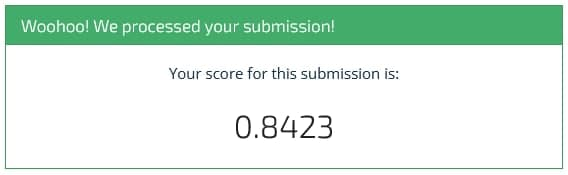